<center><h1><b><u>BA2MOTIFS</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [1]:
#BA2MOTIFS and Custom BA2MOTIFS
import torch
from torch_geometric.datasets import BA2MotifDataset, ExplainerDataset
from torch_geometric.data import Data, Dataset
from torch.utils.data import ConcatDataset, Subset
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.utils import is_undirected, degree, to_networkx, from_networkx
import matplotlib.pyplot as plt

#Custom BA2MOTIFS
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.datasets.motif_generator import HouseMotif, CycleMotif

#BA2MOTIFS graph from scratch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx #focuses on network analysis and graph theory; can create/visualize graphs
import inspect #for viewing source code
import pprint
from tqdm import tqdm
import pickle
from random import random, choice
from dataclasses import dataclass

#Explainer
import torch.nn as nn
import torch_geometric
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear, global_max_pool, global_mean_pool

## __Viewing Source Code__

In [2]:
source_code = inspect.getsource(nx.Graph)

with open('../source.py', 'w') as file:
    file.write(source_code)

## __Visualizing BA Graph__

In [3]:
def visualize_graph(G, title = '', color = 'lightblue', position = None):
    if not isinstance(G, nx.Graph):
        G = to_networkx(G, to_undirected=True)
    pos = nx.spring_layout(G)
    if position is None:
        nx.draw(G, pos, with_labels=True, node_color=color, node_size=500, font_size=10, font_weight='bold')
        plt.title(title)
    else:
        nx.draw(G, pos, ax=position, with_labels=True, node_color=color, node_size=500, font_size=10, font_weight='bold')
        position.set_title(title)

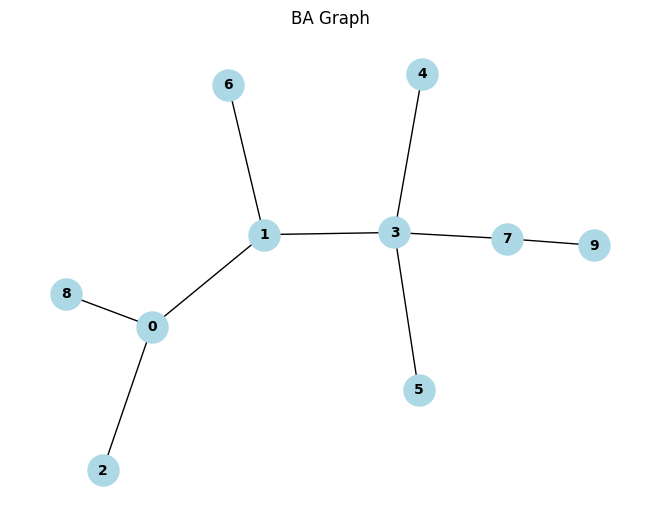

In [4]:
G = nx.barabasi_albert_graph(10, 1)
visualize_graph(G, title = "BA Graph", color = 'lightblue')

## __BA2MOTIF Dataset__

### __Analyze Degree Count__

In [5]:
ba2motifs = BA2MotifDataset(root='../data/BA2MOTIF', transform=T.ToUndirected()) #makes sure all graphs are undirected

In [6]:
def degree_distribution(graph):
    deg = degree(graph.edge_index[0], num_nodes=graph.num_nodes) #tensor of each source node in graph

    deg_int = deg.long() #long integer
    degree_counts = torch.bincount(deg_int) #tensor where tensor[i] = nodes with degree i

    print("Degree distribution:")
    for degre, count in enumerate(degree_counts):
        if count > 0:
            print(f"Degree {degre}: {count.item()} nodes")

    plt.figure(figsize=(6, 4))
    plt.bar(range(len(degree_counts)), degree_counts.numpy()) #degree_counts is height of each bar
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.title('Degree Distribution')
    plt.show()

Degree distribution:
Degree 1: 12 nodes
Degree 2: 8 nodes
Degree 3: 3 nodes
Degree 4: 1 nodes
Degree 9: 1 nodes


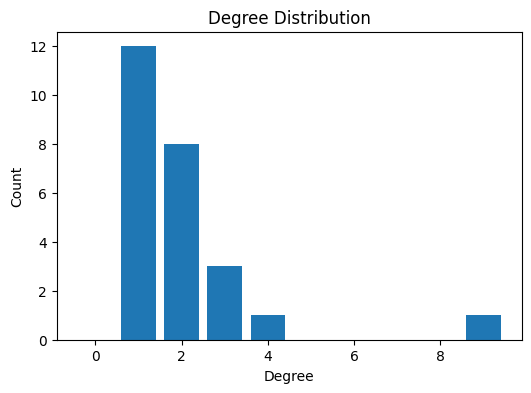

In [7]:
degree_distribution(ba2motifs[0])

### __Visualize Dataset Elements__

In [8]:
def side_by_side(graph1, graph2, title1='', title2=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    visualize_graph(graph1, title1, 'lightblue', ax1)
    visualize_graph(graph2, title2, 'lightgreen', ax2)
    
    plt.tight_layout()
    plt.show()

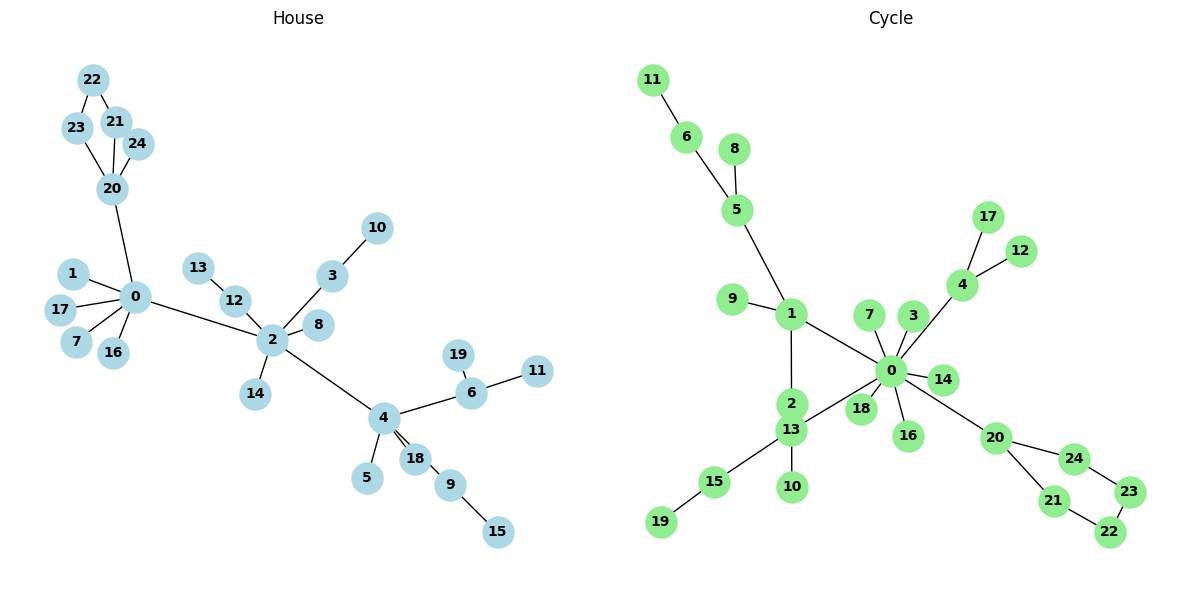

In [9]:
cycle_graph = next(graph for graph in ba2motifs if graph.y.item() == 0)
house_graph = next(graph for graph in ba2motifs if graph.y.item() == 1) #1 -> house; next() gets next item of iterator that satisfies condition

side_by_side(house_graph, cycle_graph, title1='House', title2='Cycle')

## __Partially Custom BA Motif Dataset__

In [10]:
house_set = ExplainerDataset(
    graph_generator=BAGraph(num_nodes=15, num_edges=2), #has problem fully connecting with m=1
    motif_generator=HouseMotif(),
    num_motifs=1,
    num_graphs=500,
)

cycle_set = ExplainerDataset(
    graph_generator=BAGraph(num_nodes=15, num_edges=2),
    motif_generator=CycleMotif(5),
    num_motifs=1,
    num_graphs=500,
)

ba_dataset = ConcatDataset([house_set, cycle_set])
shuffled_indices = torch.randperm(len(ba_dataset)).tolist()
ba_dataset = Subset(ba_dataset, shuffled_indices)

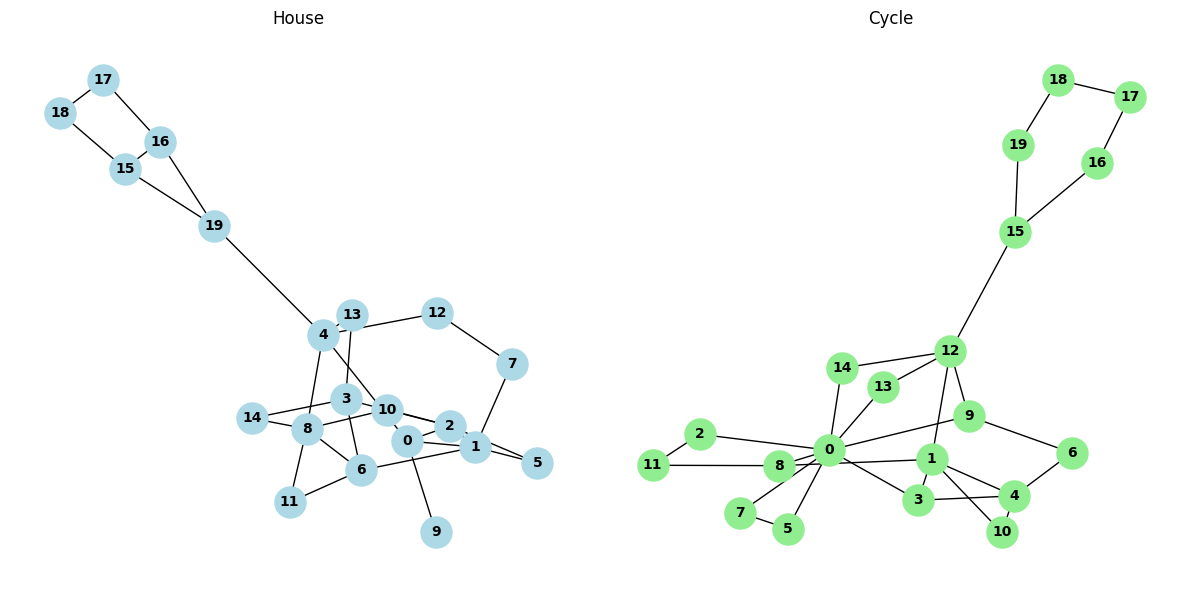

In [11]:
idx = 3
side_by_side(house_set[idx], cycle_set[idx], 'House', 'Cycle')

## __BA2Motif from Scratch__

### __Methods to Create the Dataset__

In [12]:
'''Common in Python to group related functions in a module not encapsulated in a class. NodeView node order is correct since dictionary order is 
by insertion but don't rely on this in an algorithm.'''

def create_house_motif():
    house = nx.Graph()
    house.add_edges_from([ #isomorphically a house, but may not always look like house; 4 nodes in cycle with 2 connected to 5th node
        (0, 1), (1, 2), (2, 3), (3, 0),  # square base
        (1, 4), (2, 4)  # roof
    ])
    return house

def create_cycle_motif(size):
    cycle = nx.Graph()

    cycle.add_nodes_from(range(size))
    
    for i in range(size - 1):
        cycle.add_edge(i, i+1)
    cycle.add_edge(size - 1, 0) #connect last to first to make cycle
    
    return cycle


#Give all nodes and edges same features, otherwise it's "cheating" by labeling the answer; adding features here instead of randomly in class so it is more flexible
def add_node_features(G, motif_nodes):
    for node in G.nodes():
        G.nodes[node]['motif'] = 1

def add_edge_features(G, motif_edges):
    for u, v in G.edges():
        G[u][v]['motif'] = 1


def attach_motif(G, motif):
    orig_num_nodes = G.number_of_nodes() #len(graph._node)
    orig_nodes = list(G.nodes())

    motif_node_mapping = {old: orig_num_nodes + map for map, old in enumerate(motif.nodes())} #shifts motif indices by n so it doesn't override current edges
    mapped_motif_nodes = motif_node_mapping.values()
    
    #Create a copy of the motif and add it to existing graph data (still no edge connecting motif to original graph)
    G.add_nodes_from(mapped_motif_nodes)

    #Map and add edges
    motif_edge_mapping = {(u,v): (u + orig_num_nodes, v + orig_num_nodes) for (u, v) in motif.edges()}
    mapped_motif_edges = motif_edge_mapping.values()
    G.add_edges_from(mapped_motif_edges) 
    
    #Choose attachment point and connect motif
    attachment_point = choice(orig_nodes) #random.choice chooses random element of the list of node id's as attachment point
    G.add_edge(attachment_point, orig_num_nodes) #n is first node of motif

    #Add features
    add_node_features(G, mapped_motif_nodes)
    add_edge_features(G, mapped_motif_edges)

    return G

def generate_ba2motif_dataset(num_graphs, n, m, cycle_size, motif_prob):
    dataset = [] #list of graphs
    labels = []
    
    for i in range(num_graphs):
        ba_graph = nx.barabasi_albert_graph(n, m)
        
        if random() < motif_prob: #random number from 0-1; works by Law of Large Numbers
            motif = create_cycle_motif(cycle_size)
            label = 0
        else:
            motif = create_house_motif()
            label = 1  # House motif label is 1
        
        ba_motif_graph = attach_motif(ba_graph, motif)
        
        dataset.append(ba_motif_graph)
        labels.append(label)
    
    return dataset, labels

### __Defining the Class__

#### __Approach 1: Using @dataclass__

In [18]:
@dataclass(init=True, repr=True, eq=False) #forms init, repr automatically; typehints required
class BA2MOTIFDatasetD(Dataset): #D - data class
    num_graphs: int
    n: int
    m: int
    cycle_size: int = 6
    motif_prob: float = 0.5

    def __post_init__(self):
        super().__init__() #good practice to initialize parent class (DataSet); need to initialize them for inherited methods to work
        self.dataset = self.generate_data() #depends on the fields, put in post init since it is after they are set

    def generate_data(self):
        dataset, labels = generate_ba2motif_dataset(self.num_graphs, self.n, self.m, self.cycle_size, self.motif_prob)
        data_list = []
        for graph, label in zip(dataset, labels):
            data = from_networkx(graph) #converts networkx to torch Data instance
            data.x = torch.full((data.num_nodes, 1), 1)  # Random node features; probably not necessary
            data.y = torch.tensor([label], dtype=torch.long)
            data_list.append(data)
        return data_list

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

#### __Approach 2: Standard__

In [19]:
class BA2MOTIFDatasetS(Dataset):
    def __init__(self, num_graphs: int, n: int, m: int, cycle_size: int, 
                 motif_prob: float = 0.5): #optional type hints make code more legible, ignored by Python interpreter
        
        """
        (Practicing formal documentation)
        Initializes BA2MOTIF dataset.

        Args:
            num_graphs (int): Number of graphs in the dataset.
            n (int): Number of nodes in each BA graph.
            m (int): Number of edges to attach from a new node to existing nodes.
            cycle_size (int): Size of the cycle motif.
            motif_prob (float): Probability of attached motif being cycle motif
        """

        super().__init__()
        self.num_graphs = num_graphs #calls __setattr__ if it exists; object.__setattr__ directly modifies __dict__
        self.n = n
        self.m = m
        self.cycle_size = cycle_size
        self.motif_prob = motif_prob

        self.dataset = self.generate_data() #[(nxgraph, label)...]

    def generate_data(self):
        nx_graphs, labels = generate_ba2motif_dataset(self.num_graphs, self.n, self.m, 
                                                    self.cycle_size, self.motif_prob) #creates nx graphs
        dataset = []
        for nx_graph, label in tqdm(zip(nx_graphs, labels), total = len(labels), desc="Creating Dataset", unit = " Graphs", colour="green", ncols=100):
            data = from_networkx(nx_graph)  # converts networkx to torch Data instance; used debugging to see name and dimensions of data object
            
            data.x = data.motif.unsqueeze(1).float()  # change shape from 1D tensor to 2D: [num_nodes, 1]
            #data.x = torch.ones((data.num_nodes, 1), dtype=torch.float) #Other option if features not created when generating dataset

            del data.motif #removes this attribute from namespace, not necessarily memory
        
            #Most GNN don't use edge features
            data.edge_attr = data.edge_motif.unsqueeze(1).float()
            del data.edge_motif

            data.y = torch.tensor([label], dtype=torch.long)
            
            dataset.append(data)
        return dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __repr__(self):
        return (f"{type(self).__name__}(num_graphs={self.num_graphs}, n={self.n}, m={self.m}, " #newline character only added explicitly, Python concacetenates these into singlestrin
                f"cycle_size={self.cycle_size})")

### __Creating the Dataset__

In [20]:
num_graphs = 1000
n = 20
m = 1
cycle_size = 5
    
custom_ba2 = BA2MOTIFDatasetS(num_graphs, n, m, cycle_size)

Creating Dataset: 100%|██████████████████████████████████| 1000/1000 [00:00<00:00, 2568.17 Graphs/s]


### __Saving the Dataset__

In [21]:
'''Pickle saves data to disk in byte stream (binary data more compact than text data); like MNIST from scratch. No whitespaces or other transformations necessary
to decode/deserialize the data so it is also faster.'''

#with open('../data/custom_ba2motif.pkl', 'wb') as f:
    #pickle.dump(custom_ba2, f)

'Pickle saves data to disk in byte stream (binary data more compact than text data); like MNIST from scratch. No whitespaces or other transformations necessary\nto decode/deserialize the data so it is also faster.'

### __Loading the Dataset__

In [22]:
with open('../data/custom_ba2motif.pkl', 'rb') as f:
    ba2 = pickle.load(f)

### __Analyzing Custom BA2Motif Graph__

In [23]:
def print_matrix(name, matrix):
        print(name)
        for row in matrix:
            print(" ".join(str(int(element.item())) for element in row))
        print()

In [24]:
graph = ba2[122]
motif = 'House' if graph.y.item() == 1 else 'Cycle'

#Attributes automatically assigned when creating data instance
print(f'{ba2}\n')
print(f"Number of nodes: {graph.num_nodes}")
print(f"Node features shape: {graph.x.shape}") #shape is tensor attribute
print_matrix("Node feature matrix:", graph.x)

print(f"Number of edges: {graph.num_edges}")
print(f"Edge index shape: {graph.edge_index.shape}\n")

print(f"Attached motif: {motif}")

BA2MOTIFDatasetS(num_graphs=1000, n=20, m=1, cycle_size=5)

Number of nodes: 25
Node features shape: torch.Size([25, 1])
Node feature matrix:
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

Number of edges: 50
Edge index shape: torch.Size([2, 50])

Attached motif: Cycle


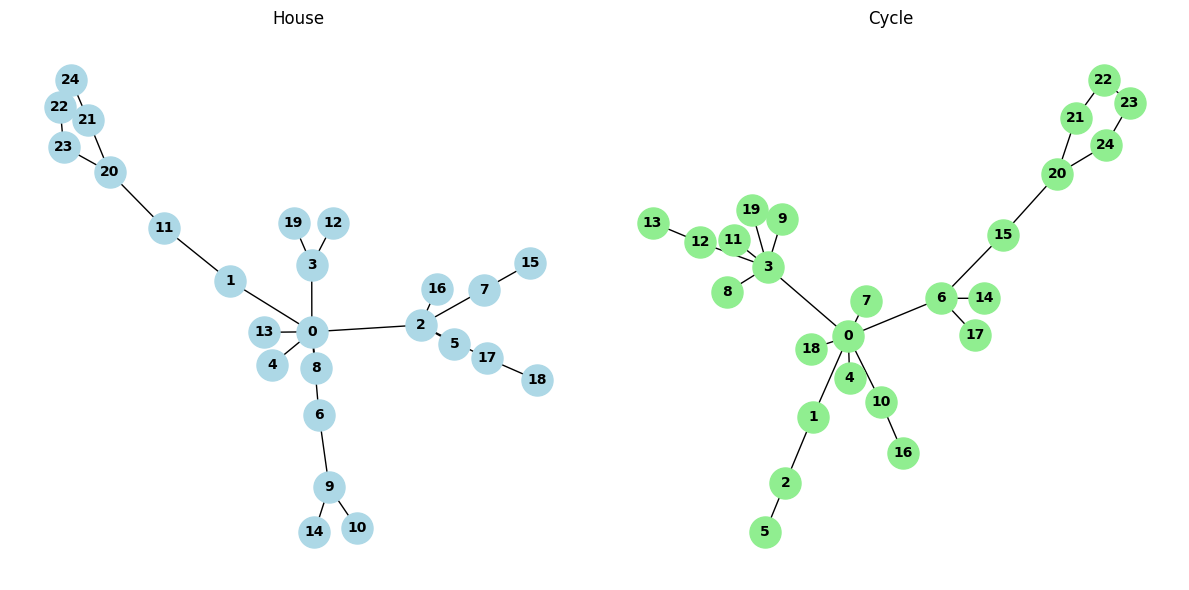

In [25]:
cycle_graph = next(graph for graph in ba2 if graph.y.item() == 0)
house_graph = next(graph for graph in ba2 if graph.y.item() == 1) #0 -> house; next() gets next item of iterator that satisfies condition

side_by_side(house_graph, cycle_graph, title1='House', title2='Cycle')

## __Creating GCN Graph Classifier__

### __Defining the Model__

In [26]:
'''Sequential adds a fixed number of layers into one object. ModuleList is dynamic so layers can easily be a hyperparameter. After mutliple layers of message passing
even if the feature is same for all nodes/edges, the values start to get a specific pattern for certain structures like motifs. GIN structure exploits graph structure well.'''
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)

        self.bn1 = nn.BatchNorm1d(hidden_dim) #normalizes the feature vector
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
        self.fc1 = nn.Linear(hidden_dim * 2, 2)
        #self.dropout = nn.Dropout(0.5) #randomly sets some elements of node feature matrix to 0
        
    
    def embed_node(self, data, edge_index):
        x = F.relu(self.bn1(self.conv1(data.x, edge_index))) #x is for one batch; do
        return F.relu(self.bn2(self.conv2(x, edge_index)))
    
    def forward(self, data):
        #For self-loop message passing
        edge_index, edge_attr = torch_geometric.utils.add_self_loops(data.edge_index, num_nodes=data.x.size(0))
        x = self.embed_node(data ,edge_index)

        #Graph embedding
        x_max = global_max_pool(x, data.batch) #captures most promiment features; data.batch is tensor saying which nodes belong to which graph
        x_mean = global_mean_pool(x, data.batch) #captures average representation
        g_embedding = torch.cat([x_max, x_mean], dim=1) #graph embedding; more diverse
        
        #Classification
        return self.fc1(g_embedding) 

### __Preparing the Data__

In [27]:
full_train_dataset = ba2[:int(len(ba2)*.8)]
test_dataset = ba2[int(len(ba2)*.8):]

train_dataset = full_train_dataset[:int(len(full_train_dataset)*.8)]
val_dataset = full_train_dataset[int(len(full_train_dataset)*.8):]

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

640
160
200


In [28]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

### __Training__

In [29]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=1, hidden_dim=32)
#model = GIN(num_features=1, num_classes=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [48]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, data.y) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader.dataset)

In [31]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data)
            pred = out.argmax(dim=1) #if max is index 1 (2nd output neuron), pred == 1 (house)
            correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [49]:
num_epochs = 200
for epoch in range(num_epochs):
    loss = train(model, train_loader, optimizer)
    train_acc = evaluate(model, train_loader)
    val_acc = evaluate(model, val_loader)
    if epoch == 0 or epoch == num_epochs - 1:
        print(f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%')

Epoch: 001, Loss: 0.0000, Train Acc: 100.00%, Val Acc: 99.38%
Epoch: 200, Loss: 0.0000, Train Acc: 100.00%, Val Acc: 99.38%


### __Loading and Saving Model__

In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), f'../models/{filename}')

In [ ]:
#save_model(model, "BA2GCN1")

In [33]:
def load_model(model, filename):
    model = GCN(input_dim=1, hidden_dim=32)
    model.load_state_dict(torch.load(f'../models/{filename}'))
    model.eval()
    return model

In [34]:
model = load_model(model, "BA2GCN")

### __Evaluation__

In [36]:
# Evaluate on test set
test_acc = evaluate(model, test_loader)
print(f'Test Accuracy: {test_acc*100:.2f}%')

Test Accuracy: 100.00%


### __Inference on New Graph__

In [52]:
custom_bag = nx.barabasi_albert_graph(n, m)

if random() < 0.5: #random number from 0-1; works by Law of Large Numbers
    motif = create_cycle_motif(cycle_size)
    label = 0
else:
    motif = create_house_motif()
    label = 1  # House motif label is 1

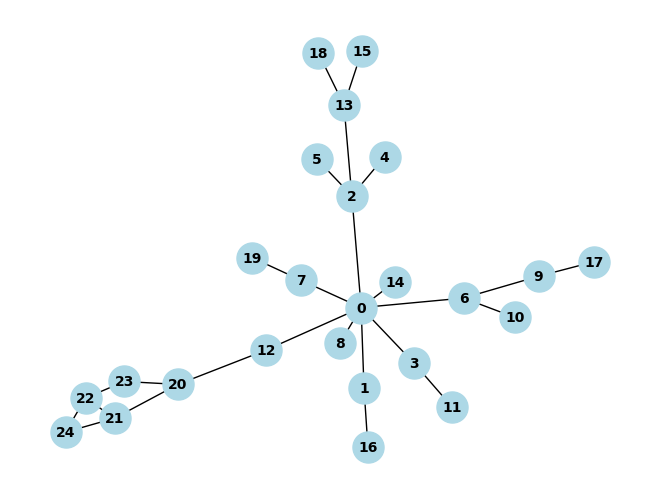

In [53]:
ba_motif_graph = attach_motif(custom_bag, motif)
visualize_graph(ba_motif_graph)

In [54]:
#Convert to torch
data = from_networkx(custom_bag)  # converts networkx to torch Data instance; used debugging to see name and dimensions of data object

data.x = data.motif.unsqueeze(1).float()  # change shape from 1D tensor to 2D: [num_nodes, 1]
data.edge_attr = data.edge_motif.unsqueeze(1).float()
data.y = torch.tensor([label], dtype=torch.long)

In [62]:
#Input to GCN
outputs = model(data)  #[batch_size, num_classes]; batch_size automatically done by PyTorch
probabilities = F.softmax(outputs, dim=1)  # dim=1 -> 2nd dim -> class dimension
prob_house = probabilities[0][1] #First batch, house probability

#Output
print(f"Probability of house: {prob_house*100:.2f}%")
motif = 'House' if prob_house > 0.5 else 'Cycle'
print(f"Attached motif: {motif}")

Probability of house: 100.00%
Attached motif: House
